In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans,DBSCAN,MeanShift
from sklearn import metrics
from itertools import cycle
import plotly.graph_objs as go
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import warnings


In [130]:
#read the data
data=pd.read_csv('primates-morphology.csv')
#display(data.head())
#drop useless columns(Because in question is mentioned that we should separate the group belonged to species so I did not consider other features like genus)
data=data.drop(['Sex','Abbreviation','Unnamed: 0','Age','Genus'],axis=1)
print(data.shape) #shape of data
data.head()

(165, 31)


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Species
0,133.426742,-101.627603,21.125902,-11.518251,4.621089,-1.519551,0.583410,-7.182875,1.410030,0.216411,...,-0.406979,0.607499,-1.309488,1.555190,-0.301822,-0.433051,0.037651,-0.279618,-0.421040,hosei
1,145.344740,-108.229812,21.121390,-14.982879,2.299335,-2.354040,0.431199,-5.266930,-1.424469,-1.451953,...,-0.569739,0.669346,-0.805954,1.583042,0.215340,-0.299550,0.709472,0.876382,-0.150133,hosei
2,137.773342,-107.162743,18.232497,-17.116294,3.016809,-5.295234,1.716895,-1.668914,-1.917478,0.601120,...,1.715016,1.269193,-0.397373,-0.813108,-0.481468,-0.243025,-0.537644,-0.140292,0.082158,rubicunda
3,141.523739,-107.436626,17.448083,-16.861469,3.382894,-1.071286,1.768891,-2.735232,-1.136700,-2.706925,...,0.972070,-0.066568,0.001964,0.656327,0.586941,-0.043639,-0.518699,-1.051100,0.542354,rubicunda
4,142.357906,-97.195294,10.511391,-6.520641,3.555506,1.652390,-0.655919,-5.373075,-1.466841,-2.626544,...,-0.174675,0.368314,-0.700708,-0.450873,0.653851,0.718319,0.798722,-0.396749,0.844772,rubicunda


In [131]:
#check the null data
data.isna().sum().sum()

0

In [132]:
#check the type of columns
data.dtypes

0          float64
1          float64
2          float64
3          float64
4          float64
5          float64
6          float64
7          float64
8          float64
9          float64
10         float64
11         float64
12         float64
13         float64
14         float64
15         float64
16         float64
17         float64
18         float64
19         float64
20         float64
21         float64
22         float64
23         float64
24         float64
25         float64
26         float64
27         float64
28         float64
29         float64
Species     object
dtype: object

In [133]:
#check the number of Species
print(len(data['Species'].value_counts()))
data['Species'].value_counts()

25


cristata        18
lar             18
polykomos       10
mitis           10
badius          10
troglodytes      9
larvatus         9
anubis           9
torquatus        9
fascicularis     8
rubicunda        8
gorilla          6
albigena         6
talapoin         5
hosei            5
leucophaeus      4
patas            4
mulatta          3
paniscus         3
fuscata          2
sphinx           2
sylvanus         2
syndactylus      2
pygmaeus         2
gelada           1
Name: Species, dtype: int64

There is no need to check the correlation because the values of columns are coordinates, not features.

In [134]:
#Check the skewness but in this case, there is no need because as Tsjerk told , the data is preprocessed and normalized before. So there is no need for any normalization or standardization.
# .skew 0: no skew, + right skew, - left skew, look for above .75 
#because the counts of skewed data are not so much,I ignored.
skew_columns = (data
                .skew()
                .sort_values(ascending=False))

skew_columns = skew_columns.loc[skew_columns > 0.75]
skew_columns

4     2.358456
1     1.272854
14    1.267799
23    0.782396
dtype: float64

In [135]:
# Scaling the dataset
datas = pd.DataFrame(data.iloc[:,:30])
datas.columns = list(data.iloc[:,:30].columns)
datas['Species'] = data['Species']
# Creating the high dimensional feature space X
data_drop = datas.drop('Species',axis=1)
X = data_drop.values
X

array([[ 1.33426742e+02, -1.01627603e+02,  2.11259023e+01, ...,
         3.76507541e-02, -2.79617731e-01, -4.21039717e-01],
       [ 1.45344740e+02, -1.08229812e+02,  2.11213897e+01, ...,
         7.09471824e-01,  8.76381939e-01, -1.50132702e-01],
       [ 1.37773342e+02, -1.07162743e+02,  1.82324974e+01, ...,
        -5.37644241e-01, -1.40291682e-01,  8.21576815e-02],
       ...,
       [-9.02041041e+01, -4.09859823e+01,  8.32862497e+01, ...,
        -1.58109640e-01, -4.16190829e-01,  1.60474491e-01],
       [-9.02482021e+01, -5.01111800e+01,  7.72850865e+01, ...,
         8.01685840e-02, -2.35063369e-01,  3.17109973e-01],
       [-8.86634478e+01, -4.38353821e+01,  7.46811974e+01, ...,
         6.08619784e-02, -2.97478831e-01,  7.23834817e-01]])

The elbow method and the silhouette coefficient are two methods of selecting the optimum number of clusters.
While the interpretation of an elbow plot is rather subjective, 
both the silhouette coefficient and elbow method can determine the number of clusters precisely.

Text(0, 0.5, 'Inertia')

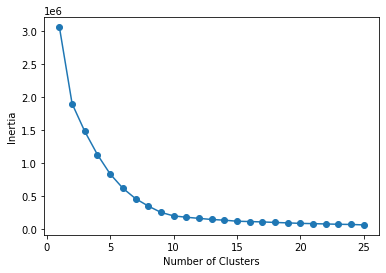

In [136]:
#Elbow Method
inertia = []
warnings.filterwarnings('ignore')
list_num_clusters = list(range(1,26))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(X)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

As you can see there is a small elbow on 2 but the good one is at 8,9 or 10, but I need to check more because maybe the elbow at 2 is made because of outlier, so I try to do silhouette.

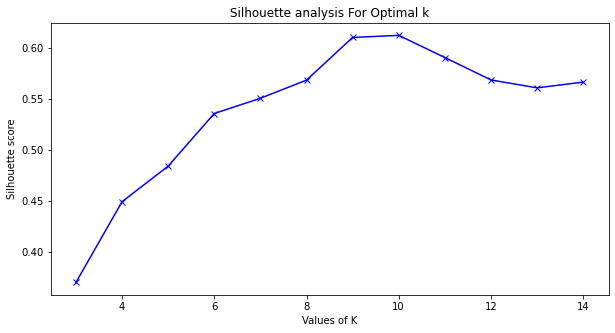

In [137]:
#silhouette coefficient
silhouette_score = []
list_num_clusters = list(range(3,15))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(X)
    cluster_labels = km.labels_
    # silhouette score
    silhouette_score.append(metrics.silhouette_score(X, cluster_labels))
plt.figure(figsize=(10,5))
plt.plot(list_num_clusters,silhouette_score,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [138]:
#create a dictionary for compare the score of silhouette
dic_silo={list_num_clusters[i]:silhouette_score[i] for i in range(len(list_num_clusters))}
dic_silo
# we can see that number 10 has the best score in silhouette 

{3: 0.3696566976187227,
 4: 0.4490608118974952,
 5: 0.4840795663958202,
 6: 0.5358127686096645,
 7: 0.5508011038223858,
 8: 0.5686666279107561,
 9: 0.610619683747988,
 10: 0.612687628735255,
 11: 0.5908729694306285,
 12: 0.5688158866724042,
 13: 0.5610763691617779,
 14: 0.5666922769216142}

You can see that based on the plot we have good points at 6,9 and 10 , and based on score 10 is the best one. So based on elbow and silhouette methods, I chose 10 for number of cluster in kmeans.

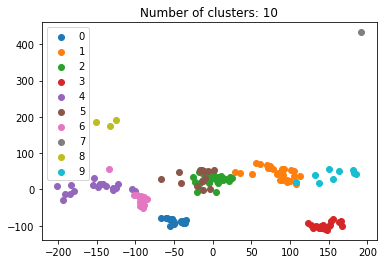

In [139]:
# K-means clusterin with 10 cluster
num_clusters = 10
km = KMeans(n_clusters=num_clusters).fit(X)
km_labels = km.fit_predict(X)
#plotting the results:
for i in np.unique(km_labels):
    plt.scatter(X[km_labels == i , 0] , X[km_labels == i , 1] , label = i)
plt.legend()
plt.title("Number of clusters: %d" % len(np.unique(km_labels)))
plt.show()

In [140]:
# 3d scatterplot of k-means using plotly
fig = plt.figure(figsize = (15,15))
trace = go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], mode='markers',marker=dict(color = km_labels, size= 5, line=dict(color= 'black',width = 3)))
layout = go.Layout(margin=dict(l=0,r=0),height = 500,width = 500)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()
#if you turn the 3d plot you can see the clustering is so good.

<Figure size 1080x1080 with 0 Axes>

I try to use mean-shift methods to check the number of clusters.

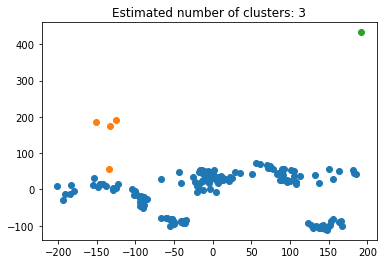

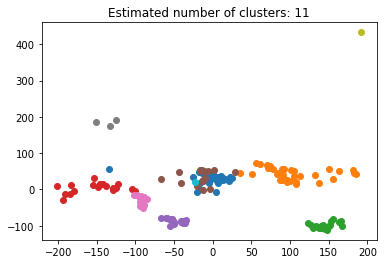

In [141]:
#Mean Shift
ms = MeanShift().fit(X)
ms_labels = ms.labels_
cluster_centers = ms.cluster_centers_

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for i in np.unique(ms_labels):
    plt.scatter(X[ms_labels == i , 0] , X[ms_labels== i , 1], label = i)
plt.title("Estimated number of clusters: %d" % len(np.unique(ms_labels)))
plt.show()

ms = MeanShift(bandwidth=80).fit(X)
ms_labels = ms.labels_
cluster_centers = ms.cluster_centers_

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for i in np.unique(ms_labels):
    plt.scatter(X[ms_labels == i , 0] , X[ms_labels== i , 1], label = i)
plt.title("Estimated number of clusters: %d" % len(np.unique(ms_labels)))
plt.show()


because of the outlier, we can see that the Meanshift does not get a good result at first without defining the value of bandwidth, and then by changing the bandwidth we can get a better result with bandwith=80 (11 clusters) but the coloring of clusters is not as good as k-means . Also because it has a bit wired shape it is better to check by dbscan, to find a good value for epsilon in dbscan try to make the below plot.

(150.0, 180.0)

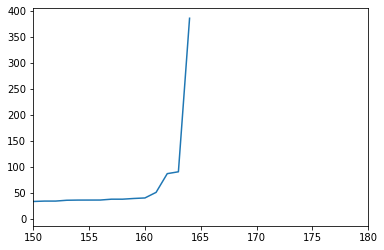

In [142]:

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlim(150,180)
# so 40 is a good value for epsilon.

number of actual clusters without noise :  8
number of noise :  13


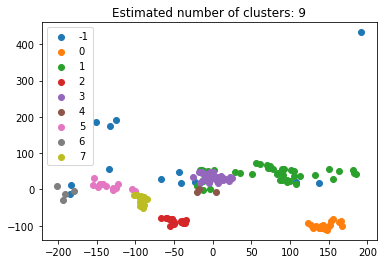

In [143]:
# DBsacn
db = DBSCAN(eps=40, min_samples=3).fit(X)
db_labels = db.fit_predict(X)
n_clusters_=len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
print('number of actual clusters without noise : ',n_clusters_)
print('number of noise : ', list(db.labels_).count(-1))
# Plot the clusters
for i in np.unique(db_labels):
    plt.scatter(X[db_labels == i , 0] , X[db_labels== i , 1], label = i)
plt.legend()
plt.title("Estimated number of clusters: %d" % len(np.unique(db_labels)))
plt.show() # showing the plot


In [144]:
# 3d scatterplot of dbsacn using plotly
import plotly.graph_objs as go
fig = plt.figure(figsize = (15,15))
trace = go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], mode='markers',marker=dict(color = db_labels, size= 5, line=dict(color= 'black',width = 3)))
layout = go.Layout(margin=dict(l=0,r=0),height = 500,width = 500)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

<Figure size 1080x1080 with 0 Axes>

The result of Dbscan shows 8 clusters and 1 cluster as a noise which is include 13 points of noise. in the visualization of the 3d plot, it is clear that we have a big cluster of pink which is not good, maybe it is better to divide it into two clusters, Also we can see some green point that is stuck on the white cluster as a noise that I think it is not noise and it must be classified as the white cluster. So to make a good decision let's show some comparison plots.

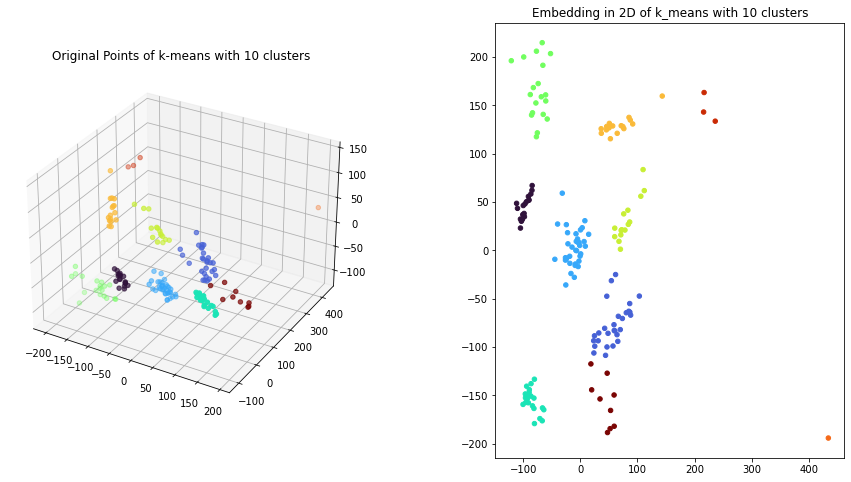

In [145]:
#using MDS to reduce the dimentions of k-means clustering in 3d and 2d with 10 clusters
mds = MDS(random_state=0)
X_transform = mds.fit_transform(X)

fig = plt.figure(2, (15,8))
ax = fig.add_subplot(121, projection='3d')
plt.scatter(X[:,0], X[:,1], zs=X[:,2],cmap='turbo' ,s=20, c=km_labels)
plt.title('Original Points of k-means with 10 clusters')

ax = fig.add_subplot(122)
plt.scatter(X_transform[:,0], X_transform[:,1],cmap='turbo', s=20, c=km_labels)
plt.title('Embedding in 2D of k_means with 10 clusters')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()



By using MDS in the right plot, it is clear that the clustering with k-means is perfect even though I think 1 of them (orange in bottom right) is outlier not actuall cluster.

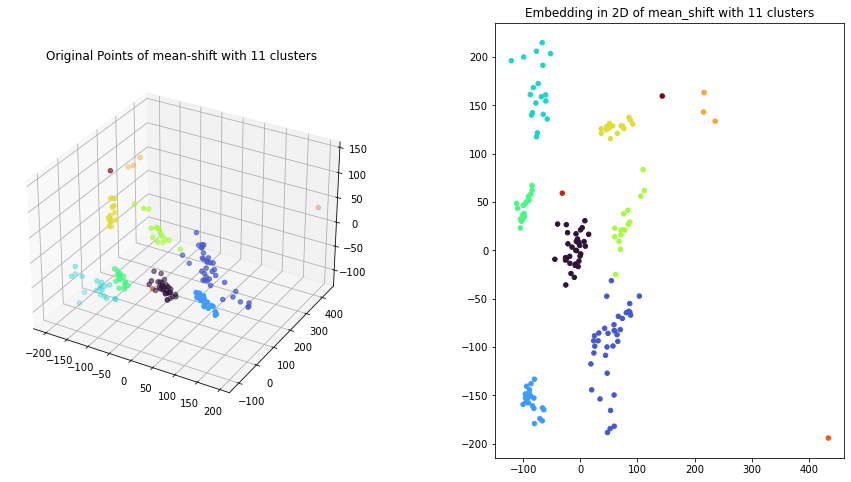

In [146]:
#using MDS to reduce the dimentions of mean_shift clustering in 3d and 2d with 11 clusters
mds = MDS(random_state=0)
X_transform = mds.fit_transform(X)

fig = plt.figure(2, (15,8))
ax = fig.add_subplot(121, projection='3d')
plt.scatter(X[:,0], X[:,1], zs=X[:,2],cmap='turbo' ,s=20, c=ms_labels)
plt.title('Original Points of mean-shift with 11 clusters')

ax = fig.add_subplot(122)
plt.scatter(X_transform[:,0], X_transform[:,1],cmap='turbo', s=20, c=ms_labels)
plt.title('Embedding in 2D of mean_shift with 11 clusters')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

Although the number of clusters in mean-shift is more than k-means, the clusters are not as good as k-means. we can see the purple cluster is too long and 3 clusters that each of them includes one point are outliers.

<function matplotlib.pyplot.show(close=None, block=None)>

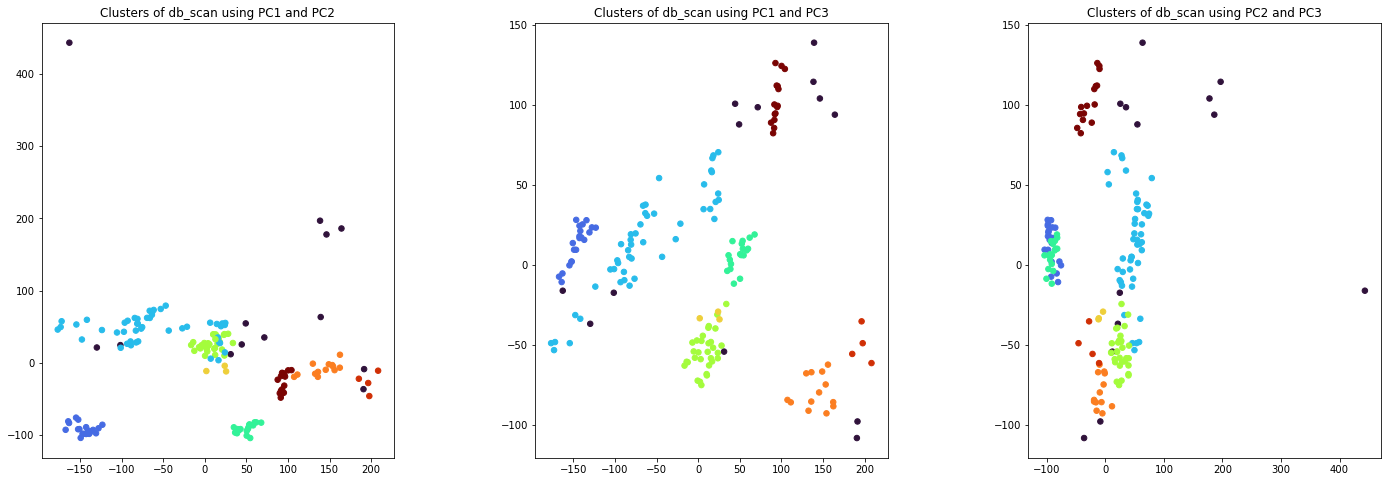

In [147]:
#using pca for dimention reduction of dbscan
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3','pc4','pc5'])
principalDf.head()

fig = plt.figure(2, (24,8))
ax = fig.add_subplot(131)
plt.scatter(principalDf['pc1'], principalDf['pc2'],s=30, cmap= 'turbo', c = db_labels)
plt.title('Clusters of db_scan using PC1 and PC2')
ax = fig.add_subplot(132)
plt.scatter(principalDf['pc1'], principalDf['pc3'], s=30, cmap='turbo', c = db_labels)
plt.title('Clusters of db_scan using PC1 and PC3')
ax = fig.add_subplot(133)
plt.scatter(principalDf['pc2'], principalDf['pc3'], s=30, cmap='turbo', c = db_labels)
plt.title('Clusters of db_scan using PC2 and PC3')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show


By using the PCA, we can reduce the dimensionality to visualize easier. Now we can see that by using the db-scan method again we have a long cluster in blue like the result of mean-shift method.

<function matplotlib.pyplot.show(close=None, block=None)>

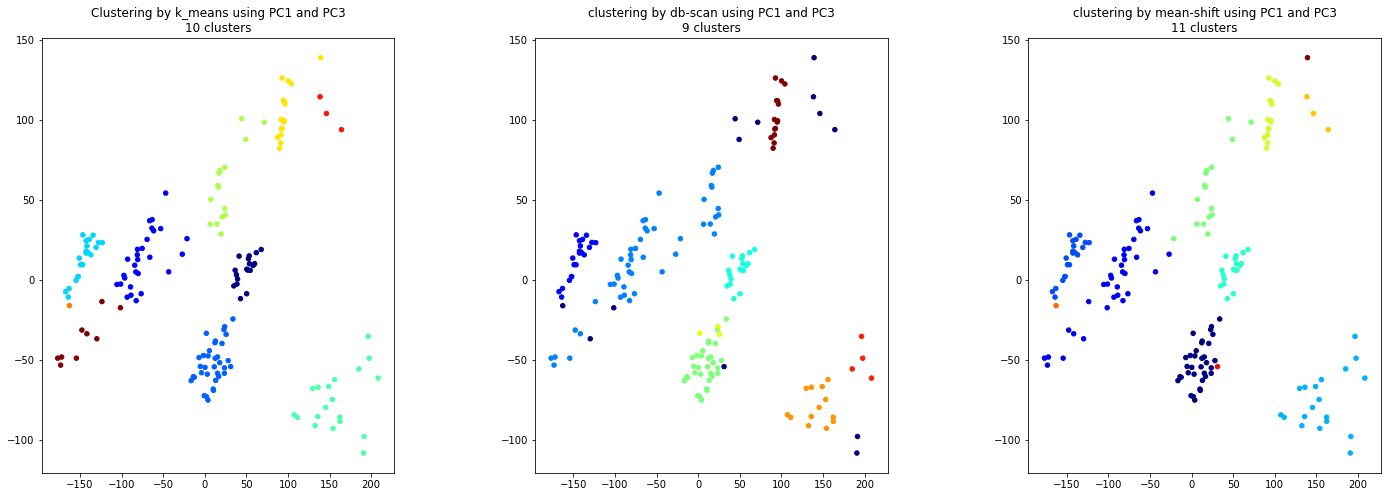

In [148]:
#using PCA for dimentionality reduction and comparison between kmeans ,meanshift and dbscan
fig = plt.figure(2, (24,8))
ax = fig.add_subplot(131)
plt.scatter(principalDf['pc1'], principalDf['pc3'],s=20, cmap='jet', c = km_labels )
plt.title('Clustering by k_means using PC1 and PC3'+'\n'+'10 clusters')
ax = fig.add_subplot(132)
plt.scatter(principalDf['pc1'], principalDf['pc3'], s=20, cmap='jet',c = db_labels)
plt.title('clustering by db-scan using PC1 and PC3'+'\n'+'9 clusters')
ax = fig.add_subplot(133)
plt.scatter(principalDf['pc1'], principalDf['pc3'], s=20, cmap='jet',c = ms_labels)
plt.title('clustering by mean-shift using PC1 and PC3'+'\n'+'11 clusters')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show

you can see in the comparison plot, that the clusters in the left plot(k-means with 10 clusters(9 cluster+1 outlier)) are divided very well without overlapping whereas in the  middle plot (dbscan with 9 clusters(8 clusters+ 1 outlier)) the light blue cluster is so long and also there is some overlapping color on some of the clusters and in the right plot(mean-shift with 11 clusters(8 clusters+ 3 outliers)) we have 3 cluster that each one include one point. Thus based on visualization I believe the best method is K-means clustering with 10 clusters.

In [149]:
#we know there is not a specific column to compare and find the accuracy. Still, with this method, we can estimate which method is better in comparison with each other approximately.
#using statistical test to evaluate the accuracy
print('k_means"',metrics.adjusted_rand_score(km_labels, datas['Species']))
print('db_scan',metrics.adjusted_rand_score(db_labels, datas['Species']))
print('mean_shift',metrics.adjusted_rand_score(ms_labels, datas['Species']))

k_means" 0.32595991993326356
db_scan 0.27638580656184153
mean_shift 0.3234111291375029


Based on the statistical test also, the k-means clustering has the best accuracy. So Based on P.G.A I believe the k-means with 10 clusters is the best way to cluster this dataset. 

By the way, I think for this dataset maybe HAC also would be a good suggestion because this method is a good method to categorize the dataset that can describe as a tree-like something that is related to inheritance and maybe pay attention more to Genus, Age or Sex can get a different result but as we know this dataset is so noisy and without ignoring the outlier working on it would be so challenging. I believe if I could spend more time on it, I will get a better and different result.

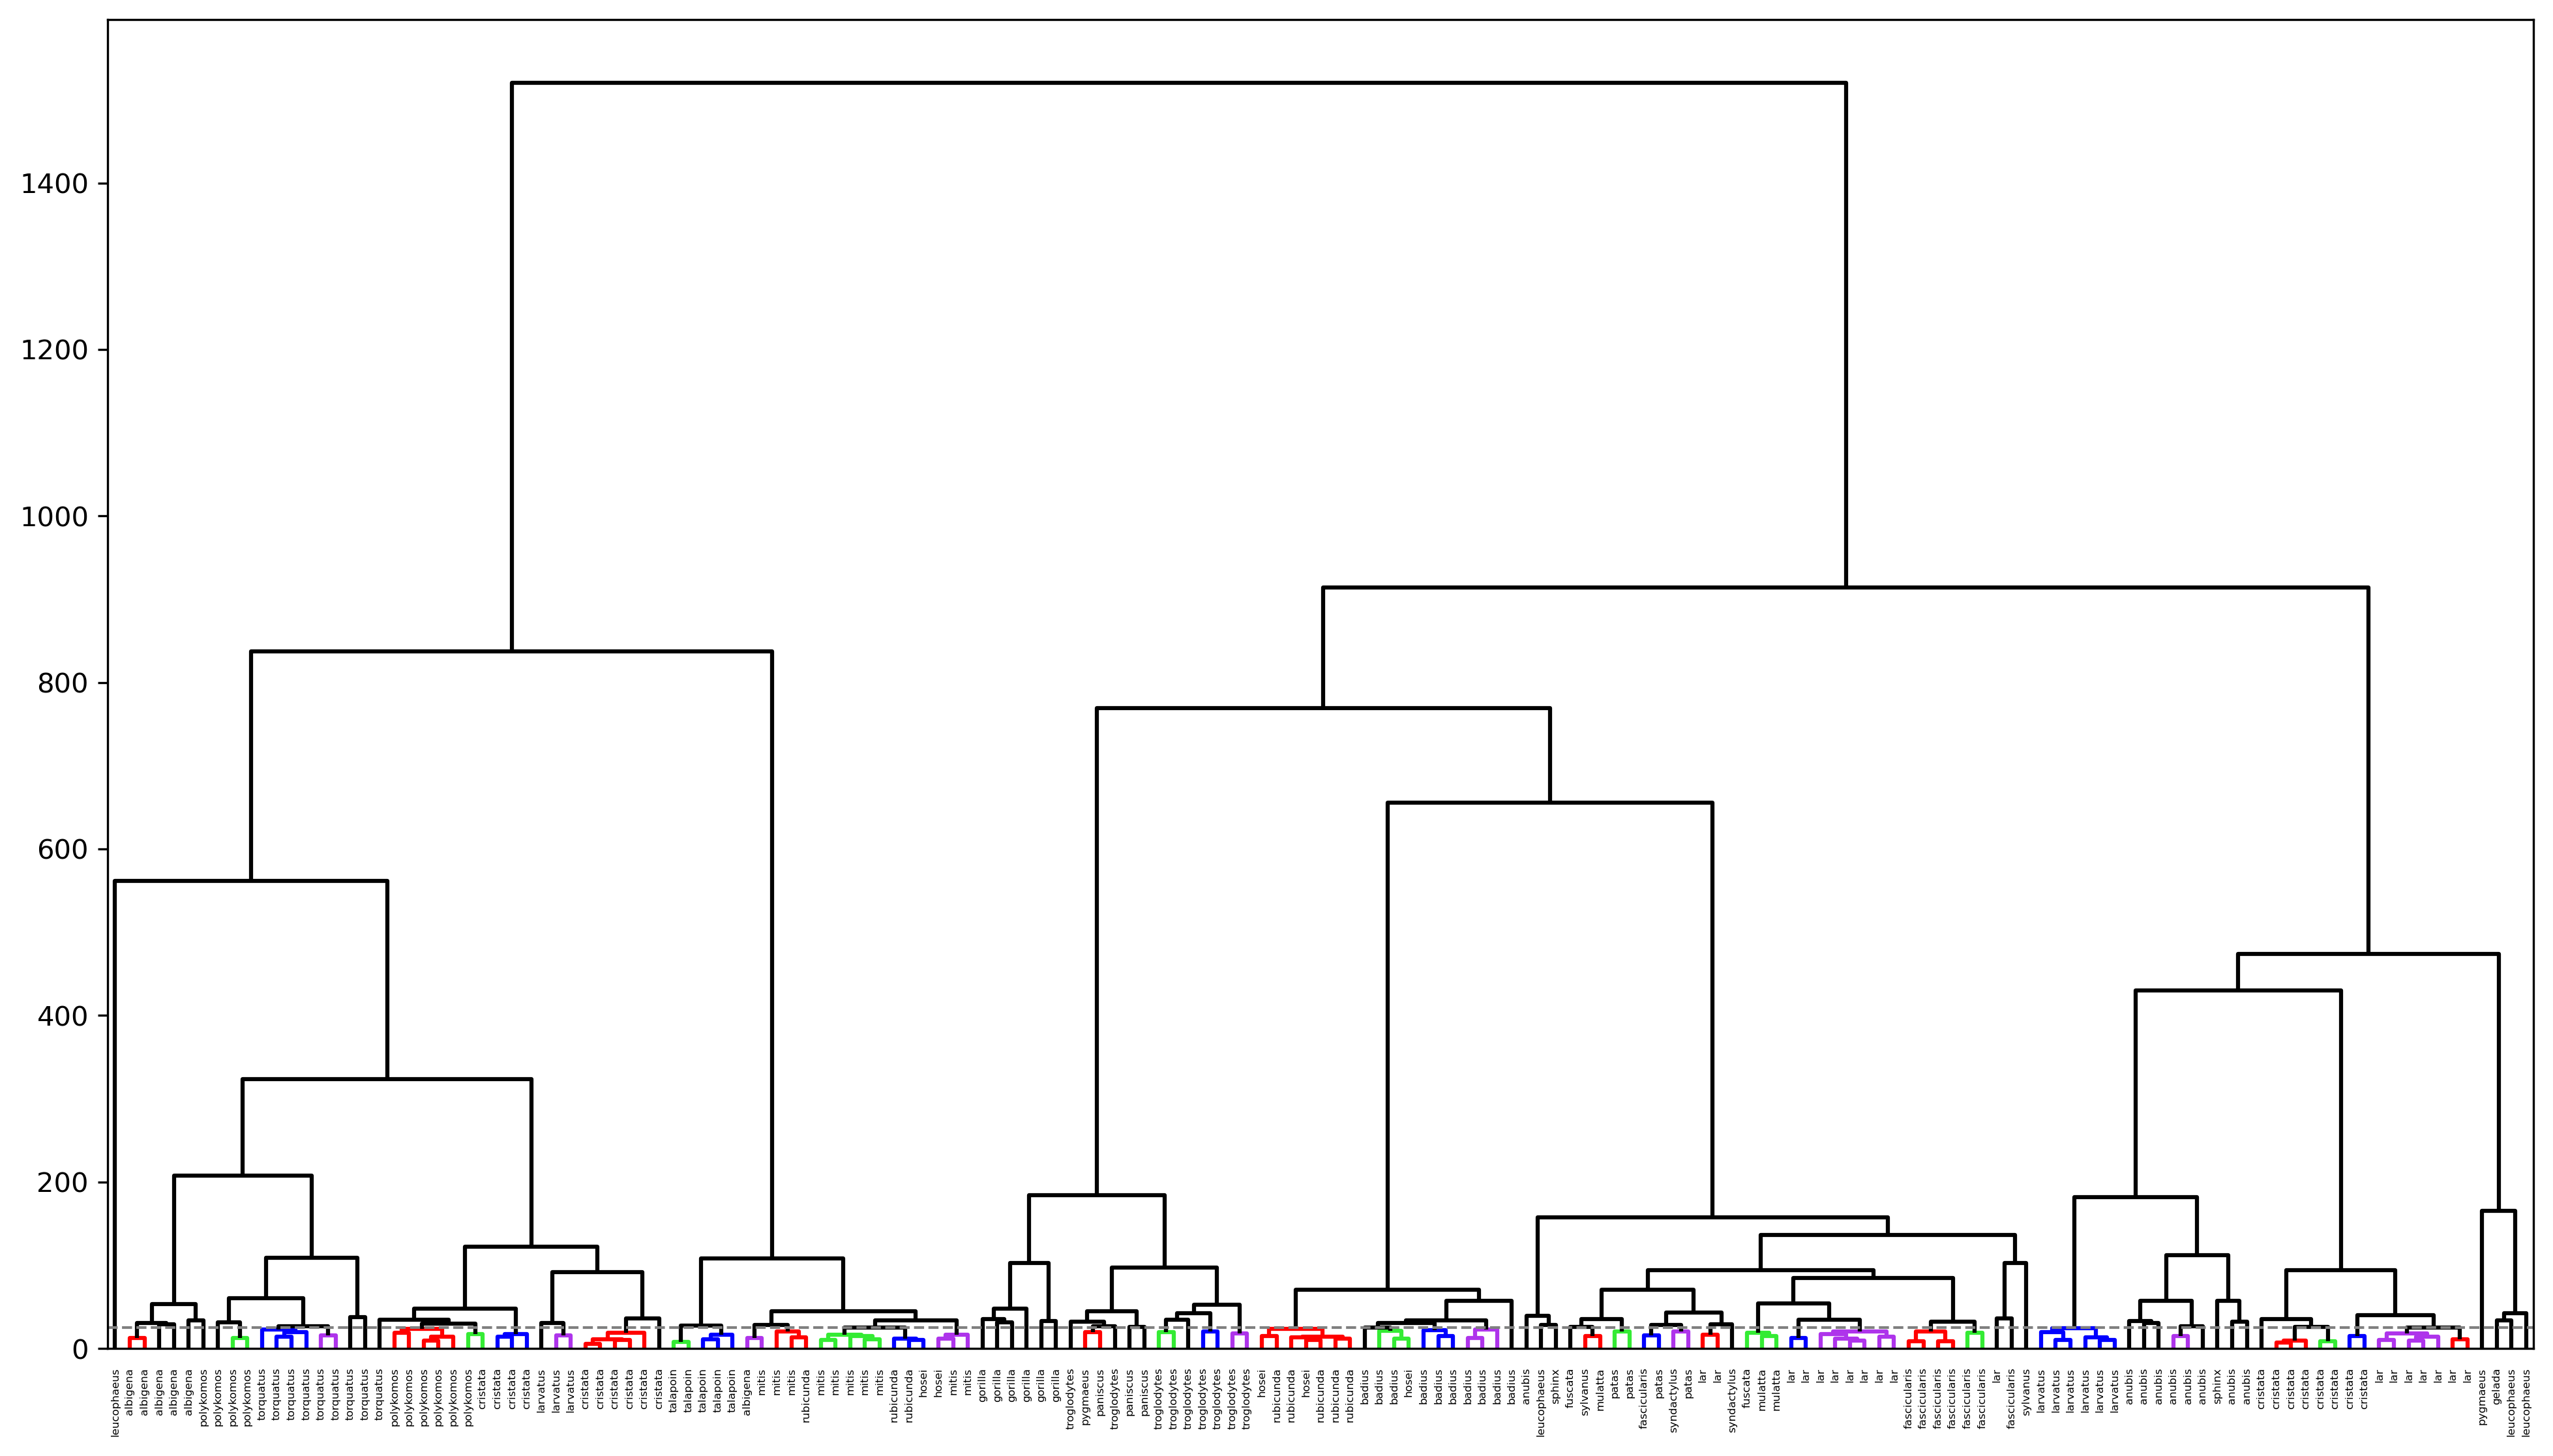

In [156]:
import scipy.cluster.hierarchy as sch 

# Create a figure
plt.figure(figsize=(16,9), dpi=300)

# Create linkage
Z = sch.linkage(X, method='ward', optimal_ordering=True) # note we use method='average'

# Specify cluster colors
sch.set_link_color_palette(['red', '#34eb34', 'blue', '#ae34eb'])

# Draw a dendrogram
sch.dendrogram(Z, leaf_rotation=90, leaf_font_size=4, labels=list(datas['Species']), 
               color_threshold=25, above_threshold_color='black')
 
# Add horizontal line
plt.axhline(y=25, c='grey', lw=1, linestyle='dashed')

# Show the plot
plt.show()